In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [36]:
xs = np.linspace(-1,1,2000)
ys_upper = np.sqrt(1 - xs**2)

# Define y values for the lower half of the circle
ys_lower = -np.sqrt(1 - xs**2)

xs = np.concatenate((xs, xs))
ys = np.concatenate((ys_upper, ys_lower))

circle = pd.DataFrame({'x':xs, 'y':ys})

In [37]:
xs = np.concatenate((xs, xs))
ys = np.concatenate((ys_upper, ys_lower))

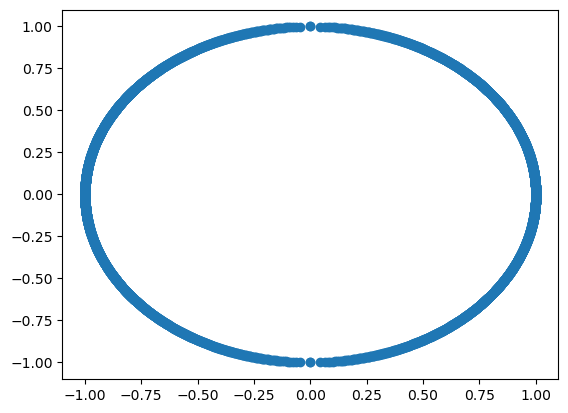

In [44]:
plt.scatter(x=circle['y'], y=circle['x'])

In [38]:
circle.tail()

,x,y
3995,0.995998,-0.089376
3996,0.996998,-0.077421
3997,0.997999,-0.063230
3998,0.998999,-0.044721
3999,1.000000,-0.000000


In [39]:
def onSegment(p, q, r): 
    if ( (q.x <= max(p.x, r.x)) and (q.x >= min(p.x, r.x)) and 
           (q.y <= max(p.y, r.y)) and (q.y >= min(p.y, r.y))): 
        return True
    return False
  
def orientation(p, q, r): 
    val = (float(q.y - p.y) * (r.x - q.x)) - (float(q.x - p.x) * (r.y - q.y)) 
    if (val > 0): 
          
        # Clockwise orientation 
        return 1
    elif (val < 0): 
          
        # Counterclockwise orientation 
        return 2
    else: 
          
        # Collinear orientation 
        return 0
  
def doIntersect(p1,q1,p2,q2): 
      
    # Find the 4 orientations required for  
    # the general and special cases 
    o1 = orientation(p1, q1, p2) 
    o2 = orientation(p1, q1, q2) 
    o3 = orientation(p2, q2, p1) 
    o4 = orientation(p2, q2, q1) 
  
    # General case 
    if ((o1 != o2) and (o3 != o4)): 
        return True
  
    # Special Cases 
  
    # p1 , q1 and p2 are collinear and p2 lies on segment p1q1 
    if ((o1 == 0) and onSegment(p1, p2, q1)): 
        return True
  
    # p1 , q1 and q2 are collinear and q2 lies on segment p1q1 
    if ((o2 == 0) and onSegment(p1, q2, q1)): 
        return True
  
    # p2 , q2 and p1 are collinear and p1 lies on segment p2q2 
    if ((o3 == 0) and onSegment(p2, p1, q2)): 
        return True
  
    # p2 , q2 and q1 are collinear and q1 lies on segment p2q2 
    if ((o4 == 0) and onSegment(p2, q1, q2)): 
        return True
  
    # If none of the cases 
    return False

In [40]:
N = 10_000
do_inter = 0
not_inter = 0

for _ in range(N):
    n = np.random.randint(0,1999,4)
    r = doIntersect(circle.iloc[n[0]], circle.iloc[n[1]],
                circle.iloc[n[2]], circle.iloc[n[3]])
    if r:
        do_inter += 1
    else:
        not_inter += 1

print(do_inter, not_inter)
print()
print(do_inter/(do_inter+not_inter))

3331 6669

0.3331
